## 状態空間モデルで時系列予測を行う（pystan）

In [1]:
# 必要なライブラリーのインポート
import numpy as np
import pandas as pd
from numpy.random import *
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6
sns.set()

# pystanの読み込み
import pystan

import warnings
warnings.filterwarnings("ignore")

In [2]:
# データの読み込み
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('../data/AirPassengers.csv')

# float型に変換
#df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={'#Passengers': 'Passengers'})

# datetime型にしてインデックスにする
#df.Month = pd.to_datetime(df.Month)
#df = df.set_index("Month")

# データの中身を確認
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
local_level = '''
data {
    int<lower=0> T; // number of learning points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(mu[t], s_y);
    }
    for(t in 2:T) {
        mu[t] ~ normal(mu[t-1], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(mu_pred[t-1], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
'''

In [4]:
stan_model = pystan.StanModel(model_code=local_level)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9bb0ebd023c1c9b55102b36db5240ae9 NOW.


In [5]:
y = df["Passengers"]
T = 130 #学習期間
M = 14 #予測期間

y_train = y[:-M]
y_test = y[-M:]

In [6]:
y_train = y[:-M]
y_test = y[-M:]

In [7]:
predict_dat = {'T': T, 'M' : M, 'Y': y_train}

In [8]:
fit_local_level = stan_model.sampling(data=predict_dat, iter=3000, chains=1, seed=10, n_jobs=1)

In [9]:
fit_local_level


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9bb0ebd023c1c9b55102b36db5240ae9.
1 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]  112.06    0.09   4.14 102.85 109.76 112.08 114.26 120.66   1971    1.0
mu[2]  118.13    0.07   4.06 110.05 115.84 118.05 120.43  126.9   3390    1.0
mu[3]  131.68    0.08   4.14 122.64 129.58 131.76 133.99 140.19   2744    1.0
mu[4]  128.86    0.09    4.4 119.92 126.75 128.96  131.1 138.03   2243    1.0
mu[5]  121.43    0.08   4.36 113.03  119.1 121.21 123.59  131.3   2967    1.0
mu[6]  135.11    0.08   4.28  126.2 132.88 135.11 137.32 144.46   2759    1.0
mu[7]  147.91    0.09   4.15 138.37 145.71 147.99 150.23 156.43   2172    1.0
mu[8]  147.78    0.09    4.3 137.78 145.68 147.84 150.11 156.43   2481    1.0
mu[9]  135.81    0.08   4.55 125.87 133.42 135.92 138.39 144.97   326

In [10]:
# サンプリング結果の抽出
ms_local_level = fit_local_level.extract()
y_pred = ms_local_level['y_pred'].mean(axis=0)

In [11]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level['y_pred'], q=quantile, axis=0).T
colname = ['p5', 'p95']
df_pred = pd.DataFrame(per_5_95, columns=colname)

In [12]:
df_pred

,p5,p95
0,105.748057,118.926102
1,111.416992,124.701562
2,124.497620,137.997765
3,121.528787,136.170025
4,114.541684,129.109279
...,...,...
139,244.615422,563.949389
140,235.327713,563.772650
141,232.437850,570.964966
142,225.080298,581.487162


In [13]:
# 予測値を追加
df_pred['y_pred'] = y_pred

In [14]:
mu_hat = ms_local_level['mu'].mean(axis=0)

In [15]:
# 状態の推定値を追加
df_pred['mu_hat'] = np.nan
df_pred.loc[0:129,'mu_hat'] = mu_hat

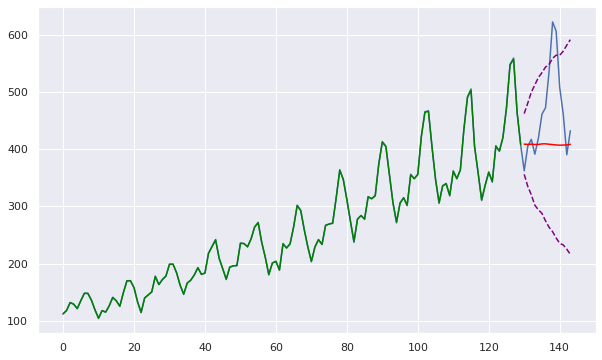

In [16]:
df.plot(y="Passengers", legend=False) # 目的変数
plt.plot(df_pred[['p5','p95']][-14:], linestyle="dashed", color='purple') # 予測区間
plt.plot(df_pred[['y_pred']][-14:], color='red') # 予測値
plt.plot(mu_hat, color='green') # 状態
plt.show()